# <신용카드 고객 분석 및 이탈고객 예측>

고객이 자사 신용카드를 더이상 사용하지 않고 이탈해버리는 것은 은행에서는 큰 비즈니스적 문제이다. 따라서 어떤 요소들이 고객이탈과 관련있는지 파악하고, 이탈을 방지할 수 있는 방안들을 마련할 필요가 있다.

이를 위해 10127개의 고객 데이터를 분석한 뒤, Random Forest와 XGBoost 두 모델을 활용해 어떤 요소들이 고객의 이탈에 가장 관련이 있는지 파악한다.

[가설] <br>
소득이 적을 수록, 카드 등급이 낮을 수록, 카드사용 금액이 적을 수록 이탈 가능성이 높을 것이다.

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import warnings
warnings.filterwarnings(action = 'ignore')

# 1. 데이터 확인

In [172]:
df = pd.read_csv('./data/BankChurners/BankChurners.csv')

In [173]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,60K - 80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,80K - 120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than 40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60K - 80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### 컬럼 정보

- CLIENTNUM ------------------ 클라이언트 고유번호
- <strong>Attrition_Flag ------------------ 계정이 존재/폐쇄 여부 -> 타겟값</strong>
- Customer_Age --------------- 고객의 연령
- Gender -------------------------- M = 남성, F = 여성
- Dependent_count ------------ 부양 가족 수 
- Education_Level ------------- 계좌 소유자의 최종 학력             
- Marital_Status ---------------- 기혼, 미혼, 이혼, 알 수 없음               
- Income_Category ------------ 계정 소유자의 연간 소득 범주
- Card_Category --------------- 카드 유형 (블루, 실버, 골드, 플래티넘)         
- Months_on_book ------------- 은행과의 거래 기간(월)
- Total_Relationship_Count -- 고객이 보유한 카드 수
- Months_Inactive_12_mon -- 지난 12 개월 동안 비활성 상태인 개월 수
- Contacts_Count_12_mon -- 지난 12 개월 동안의 연락 횟수      
- Credit_Limit -------------------- 신용 카드 신용 한도
- Total_Revolving_Bal --------- 신용 카드의 총 잔액         
- Avg_Open_To_Buy ---------- 신용 한도 구매 가능 금액 (지난 12 개월 평균)
- Total_Amt_Chng_Q4_Q1 -- 거래 금액의 변동 (Q1 대비 Q4)
- Total_Trans_Amt ------------- 총 거래 금액 (지난 12 개월)
- Total_Trans_Ct --------------- 총 거래 수 (지난 12 개월)    
- Total_Ct_Chng_Q4_Q1 ---- 거래 건수 변경 (Q1 대비 Q4)   
- Avg_Utilization_Ratio ------- 평균 카드 사용률

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

데이터는 10127개의 행과 21개의 열로 이루어져 있다.

In [175]:
# NaN 값이 있는지 확인
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# 2. EDA

In [176]:
from matplotlib import font_manager, rc
import platform

# 이미지에 한글 표시 설정
if platform.system() == 'Windows': # 윈도우인 경우 맑은고딕
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else :  # Mac인 경우 애플고딕
    rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

## 2.1. 범주형 데이터 EDA

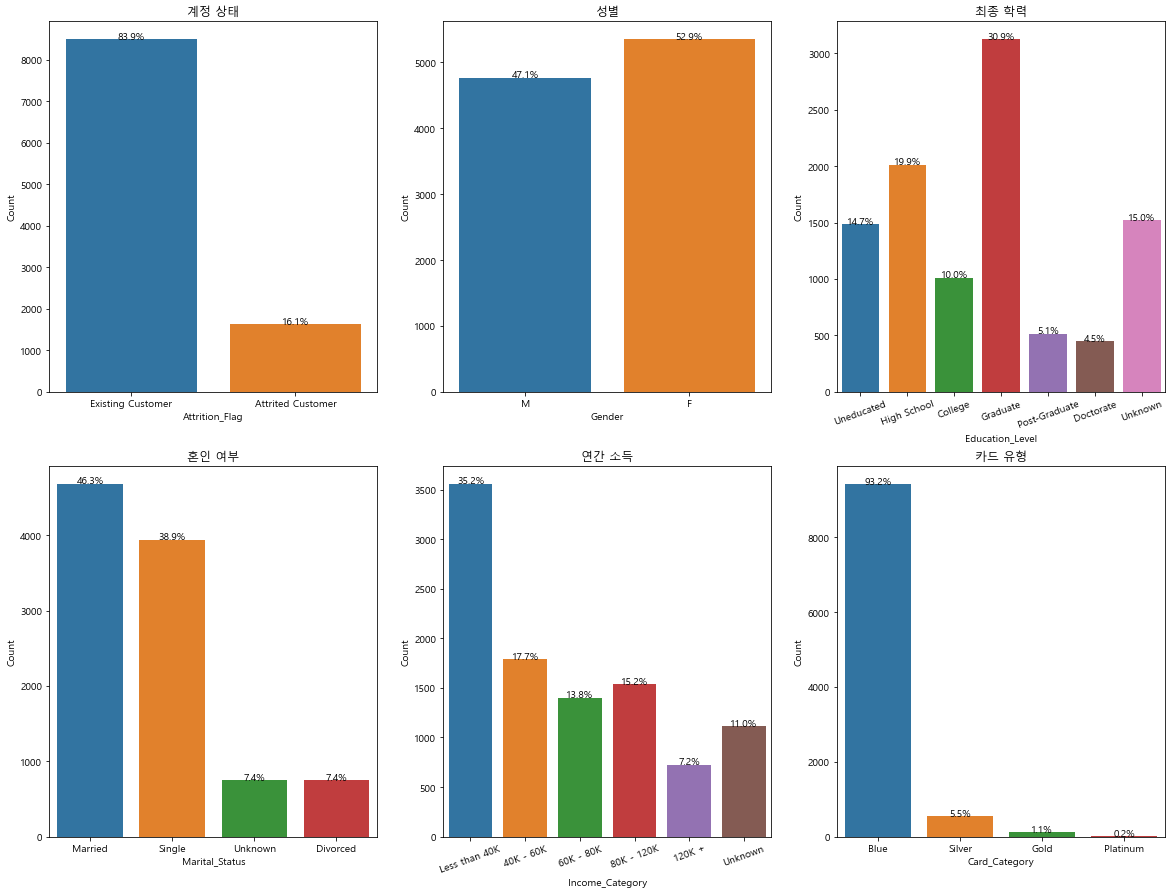

In [177]:
# 각 변수에 알리아스를 지정해서 그래프 그리기
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.countplot(data=df, x='Attrition_Flag', ax=ax1)
sns.countplot(data=df, x='Gender', ax=ax2)
sns.countplot(data=df, x='Education_Level', ax=ax3,
              order=["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate", "Unknown"])
sns.countplot(data=df, x='Marital_Status', ax=ax4)
sns.countplot(data=df, x='Income_Category', ax=ax5, 
              order=["Less than 40K", "40K - 60K", "60K - 80K", "80K - 120K", "120K +", "Unknown"])
sns.countplot(data=df, x='Card_Category', ax=ax6,
              order=["Blue", "Silver", "Gold", "Platinum"])

# % 표현
total = float(len(df))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in ax:
    for p in i.patches:
        height = p.get_height()
        i.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100 * height/total),
                ha="center") 


# 제목 추가
ax1.set(ylabel='Count', title='계정 상태')
ax2.set(ylabel='Count', title='성별')
ax3.set(ylabel='Count', title='최종 학력')
ax4.set(ylabel='Count', title='혼인 여부')
ax5.set(ylabel='Count', title='연간 소득')
ax6.set(ylabel='Count', title='카드 유형')


plt.sca(ax3)
plt.xticks(rotation=20)
plt.sca(ax5)
plt.xticks(rotation=20)

plt.show()

## 2.2. 연속형 데이터 EDA

[Text(0.5, 1.0, '지난 12개월 동안의 연락 횟수')]

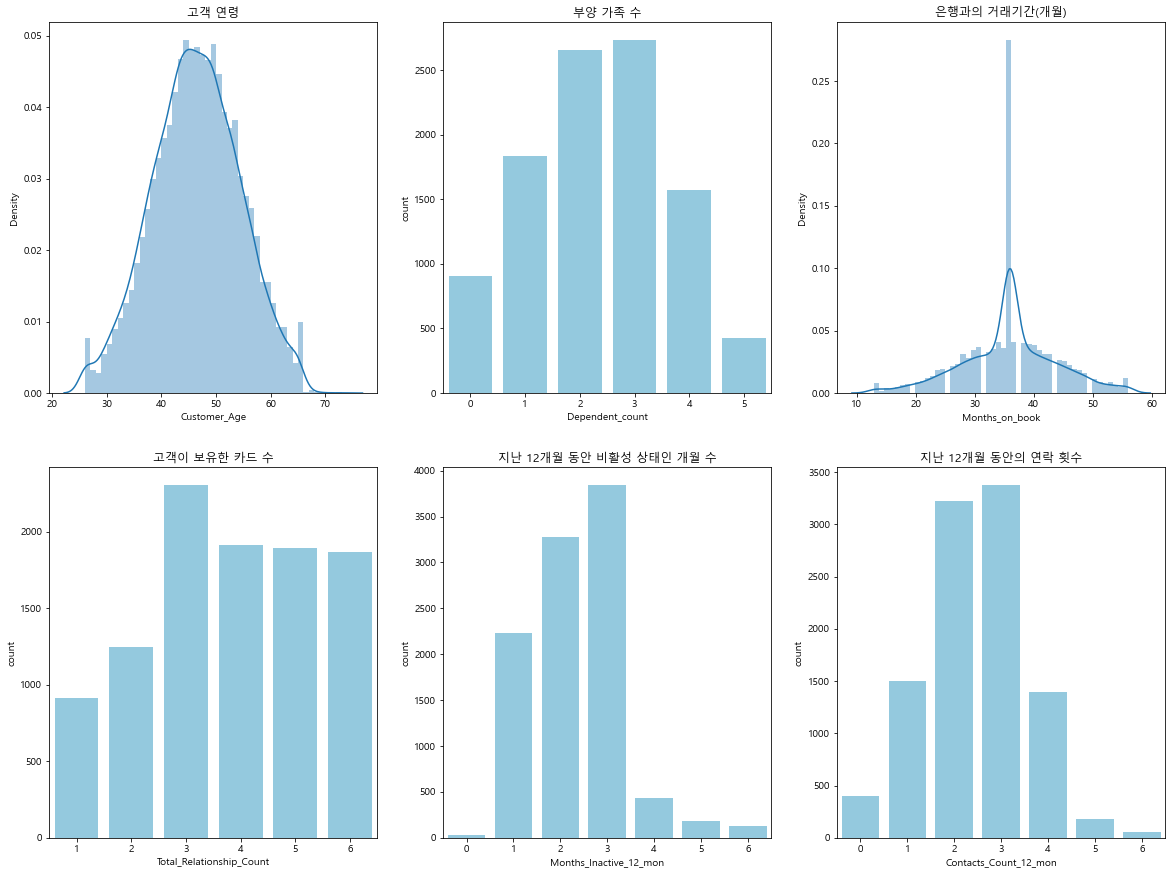

In [178]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.distplot(df['Customer_Age'], ax=ax1)
sns.countplot(data=df, x='Dependent_count', ax=ax2, color="skyblue")
sns.distplot(df['Months_on_book'], ax=ax3)
sns.countplot(data=df, x='Total_Relationship_Count', ax=ax4, color="skyblue")
sns.countplot(data=df, x='Months_Inactive_12_mon', ax=ax5, color="skyblue")
sns.countplot(data=df, x='Contacts_Count_12_mon', ax=ax6, color="skyblue")

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='고객이 보유한 카드 수')
ax5.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax6.set(title='지난 12개월 동안의 연락 횟수')

In [179]:
df[['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']].describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000


<AxesSubplot:xlabel='Months_on_book', ylabel='count'>

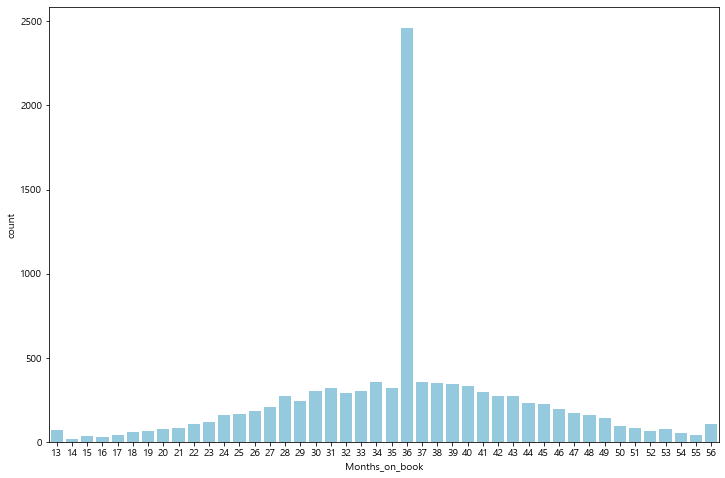

In [180]:
plt.figure(figsize = (12, 8))
sns.countplot(data=df, x='Months_on_book', color="skyblue")

은행과의 거래기간이 36개월인 사람이 압도적으로 많다는 것이 눈에 띈다.

In [181]:
# month_36 = df[df['Months_on_book'] == 36]
# month_36

[Text(0.5, 1.0, '지난 12개월 동안의 연락 횟수')]

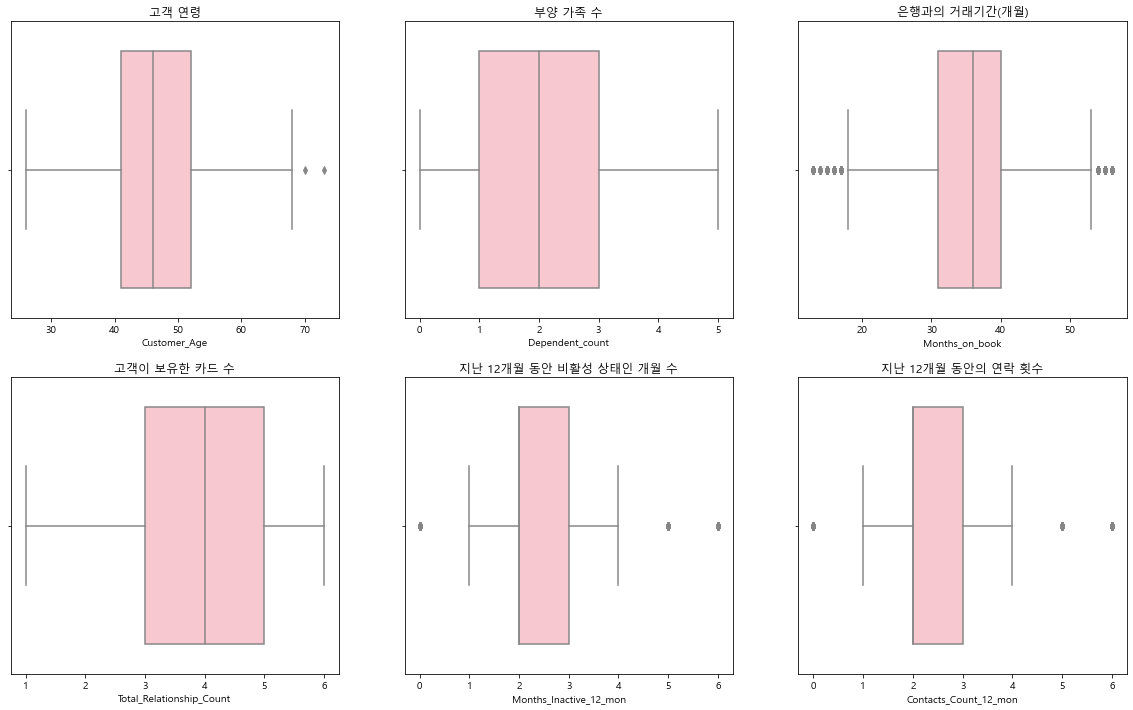

In [182]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Customer_Age', ax=ax1, color="pink")
sns.boxplot(data=df, x='Dependent_count', ax=ax2, color="pink")
sns.boxplot(data=df, x='Months_on_book', ax=ax3, color="pink")
sns.boxplot(data=df, x='Total_Relationship_Count', ax=ax4, color="pink")
sns.boxplot(data=df, x='Months_Inactive_12_mon', ax=ax5, color="pink")
sns.boxplot(data=df, x='Contacts_Count_12_mon', ax=ax6, color="pink")

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='고객이 보유한 카드 수')
ax5.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax6.set(title='지난 12개월 동안의 연락 횟수')

[Text(0.5, 1.0, '총 거래 수 (지난 12 개월)')]

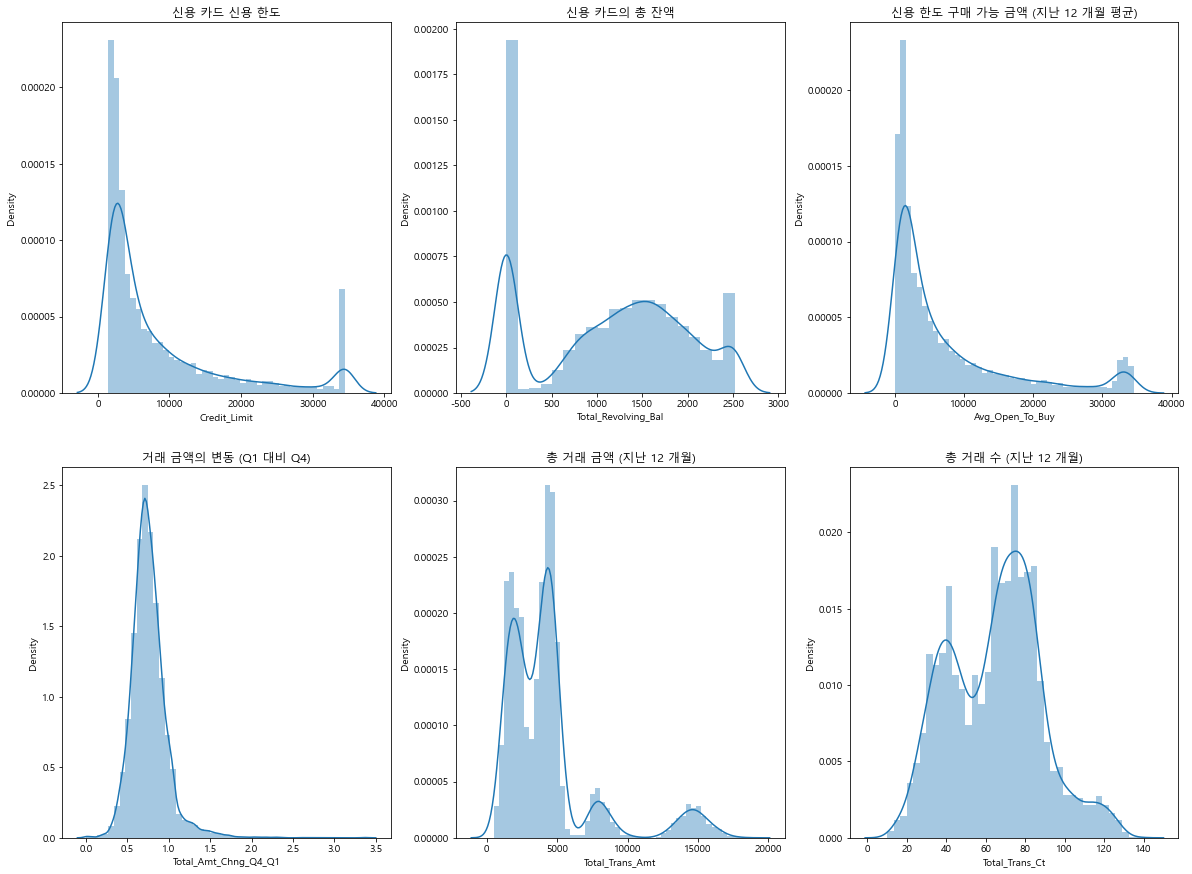

In [183]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.distplot(df['Credit_Limit'], ax=ax1)
sns.distplot(df['Total_Revolving_Bal'], ax=ax2)
sns.distplot(df['Avg_Open_To_Buy'], ax=ax3)
sns.distplot(df['Total_Amt_Chng_Q4_Q1'], ax=ax4)
sns.distplot(df['Total_Trans_Amt'], ax=ax5)
sns.distplot(df['Total_Trans_Ct'], ax=ax6)

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')
ax5.set(title='총 거래 금액 (지난 12 개월)')
ax6.set(title='총 거래 수 (지난 12 개월)')

In [184]:
df[['Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct']].describe()

,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695
std,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570
min,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000
25%,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000
50%,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000
75%,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000
max,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000


In [185]:
df['Total_Revolving_Bal'][df['Total_Revolving_Bal'] > 0].describe()

count    7657.000000
mean     1537.915372
std       549.128757
min       132.000000
25%      1132.000000
50%      1524.000000
75%      1935.000000
max      2517.000000
Name: Total_Revolving_Bal, dtype: float64

[Text(0.5, 1.0, '총 거래 수 (지난 12 개월)')]

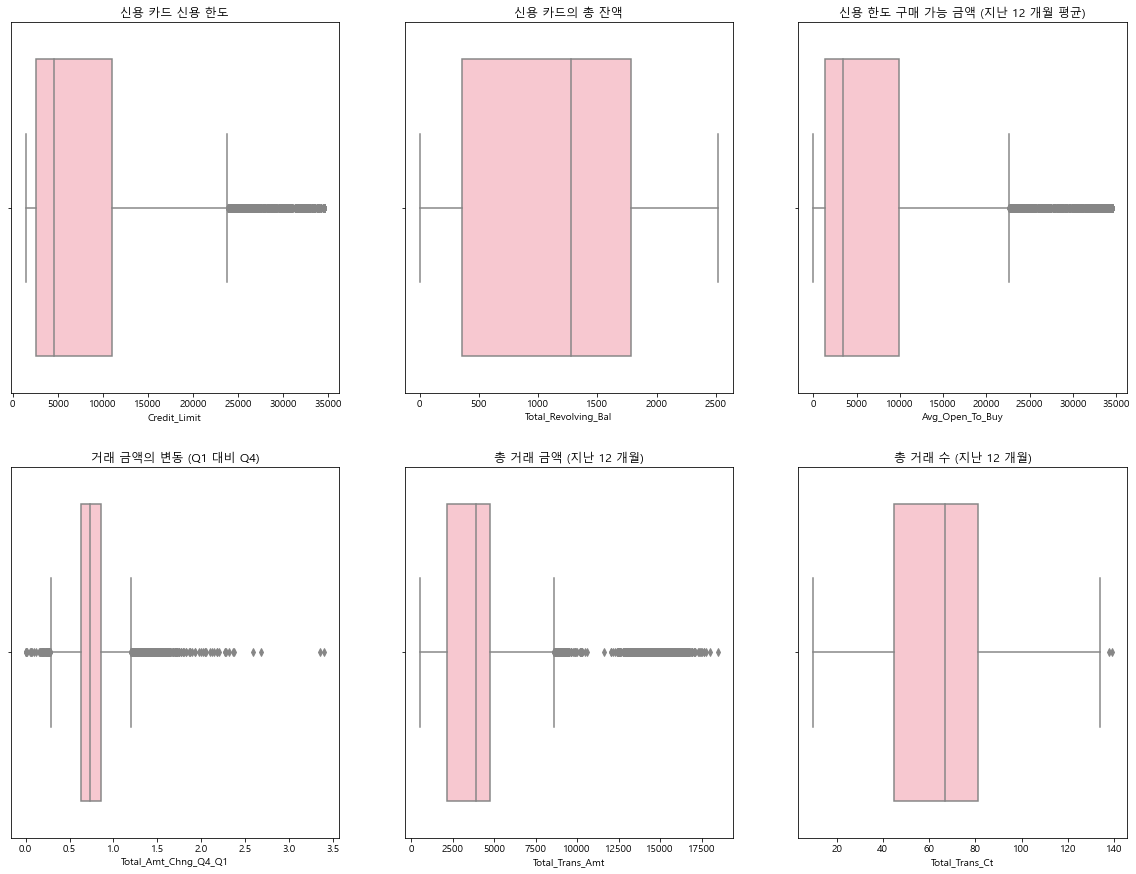

In [186]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.boxplot(data=df, x='Credit_Limit', ax=ax1, color='pink')
sns.boxplot(data=df, x='Total_Revolving_Bal', ax=ax2, color='pink')
sns.boxplot(data=df, x='Avg_Open_To_Buy', ax=ax3, color='pink')
sns.boxplot(data=df, x='Total_Amt_Chng_Q4_Q1', ax=ax4, color='pink')
sns.boxplot(data=df, x='Total_Trans_Amt', ax=ax5, color='pink')
sns.boxplot(data=df, x='Total_Trans_Ct', ax=ax6, color='pink')

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')
ax5.set(title='총 거래 금액 (지난 12 개월)')
ax6.set(title='총 거래 수 (지난 12 개월)')

In [187]:
df[df['Total_Amt_Chng_Q4_Q1'] > 3.0]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8,710930508,Existing Customer,37,M,3,Uneducated,Single,60K - 80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
12,710599683,Existing Customer,56,M,1,College,Single,80K - 120K,Blue,36,...,6,0,11751.0,0,11751.0,3.397,1539,17,3.250,0.000


[Text(0.5, 1.0, '평균 카드 사용률')]

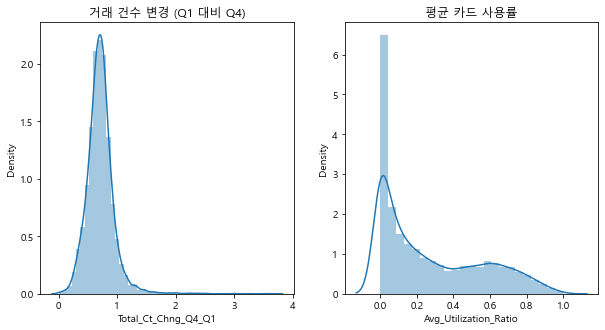

In [188]:
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(10,5)

sns.distplot(df['Total_Ct_Chng_Q4_Q1'], ax=ax1)
sns.distplot(df['Avg_Utilization_Ratio'], ax=ax2)

ax1.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax2.set(title='평균 카드 사용률')

In [189]:
df[['Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']].describe()

,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000
mean,0.712222,0.274894
std,0.238086,0.275691
min,0.000000,0.000000
25%,0.582000,0.023000
50%,0.702000,0.176000
75%,0.818000,0.503000
max,3.714000,0.999000


[Text(0.5, 1.0, '평균 카드 사용률')]

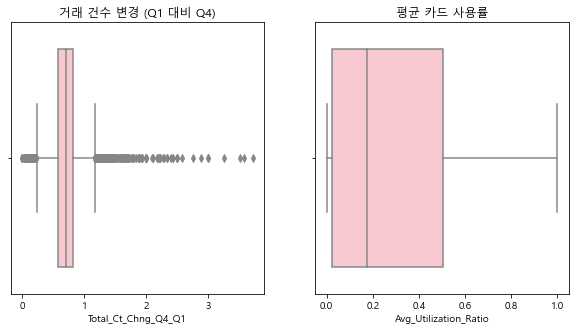

In [190]:
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(10,5)

sns.boxplot(data=df, x='Total_Ct_Chng_Q4_Q1', ax=ax1, color="pink")
sns.boxplot(data=df, x='Avg_Utilization_Ratio', ax=ax2, color="pink")

ax1.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax2.set(title='평균 카드 사용률')

- EDA를 통해 각 변수들을 시각화하여 살펴보고 이상치를 확인했다.
- 이상치들이 더러 있었지만, 비정상적으로 극단적인 이상치(ex, 1000회 이상의 거래 횟수)는 발견되지 않았기에 확인된 이상치는 모두 수용하기로 결정했다.

# 3. 원핫 인코딩(One-Hot Encoding)

In [191]:
train = pd.get_dummies(df,
                       columns = ['Attrition_Flag', 'Gender', 'Education_Level',
                                  'Marital_Status', 'Income_Category', 'Card_Category'])
train.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_120K +,Income_Category_40K - 60K,Income_Category_60K - 80K,Income_Category_80K - 120K,Income_Category_Less than 40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


In [192]:
train.columns

Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag_Attrited Customer', 'Attrition_Flag_Existing Customer',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_120K +', 'Income_Category_40K - 60K',
       'Income_Category_60K - 80K', 'Income_Category_80K - 120K',
       'Income_Category_Less than 40K', 'Income_Category_Unknown',
    

In [193]:
# target 변수인 Attrition_Flag_Attrited Customer와
# 직접적인 target변수는 아니지만 관련이 있는 Attrition_Flag_Existing Customer를 제거하고
# 나머지 변수를 input_var에 담는다.
input_var = ['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_120K +', 'Income_Category_40K - 60K',
       'Income_Category_60K - 80K', 'Income_Category_80K - 120K',
       'Income_Category_Less than 40K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'
]

# 4. 다중공선성(multicollinearity) 검사

In [194]:
train.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_120K +,Income_Category_40K - 60K,Income_Category_60K - 80K,Income_Category_80K - 120K,Income_Category_Less than 40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


In [195]:
corr = train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_120K +,Income_Category_40K - 60K,Income_Category_60K - 80K,Income_Category_80K - 120K,Income_Category_Less than 40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
Customer_Age,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114,0.017312,-0.017312,-0.014788,0.025199,-0.000203,0.001199,-0.022081,0.005057,0.005377,-0.042614,0.047364,-0.011248,-0.026694,0.044332,-0.013804,-0.017869,0.005381,-0.002573,-0.002264,0.021409,-0.011901,0.006515,-0.019425
Dependent_count,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135,-0.004563,0.004563,0.003369,-0.003368,0.000671,-0.013127,0.009459,0.002190,0.004922,0.006697,0.014385,-0.040707,0.041743,0.024831,-0.013493,0.028975,0.047611,-0.046785,-0.019205,-0.027671,0.027035,0.003555,0.017322
Months_on_book,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541,0.006728,-0.006728,-0.010281,0.024114,0.003531,0.002637,-0.016703,0.001099,-0.003610,-0.027678,0.033194,-0.005065,-0.026145,0.033532,-0.003204,-0.016635,0.007720,-0.004300,-0.007688,0.014934,-0.005426,0.001791,-0.014357
Total_Relationship_Count,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663,-0.003157,0.003157,-0.013582,-0.009077,0.005397,-0.001707,0.012050,0.008202,-0.003969,0.009276,0.017001,-0.017329,-0.009376,-0.006090,-0.008747,0.005475,0.001185,0.005109,0.000490,0.085789,-0.055678,-0.043289,-0.060566
Months_Inactive_12_mon,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503,0.011163,-0.011163,0.004038,0.002432,0.005885,-0.005575,-0.006240,0.010127,-0.012378,0.001796,-0.007065,0.008973,-0.005053,-0.002661,-0.021437,-0.004616,-0.005910,0.018848,0.011446,0.016565,-0.003283,-0.004013,-0.016034
Contacts_Count_12_mon,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471,-0.039987,0.039987,-0.008996,-0.001016,0.002660,-0.003927,-0.006878,0.012596,0.000843,-0.008389,0.001598,0.007997,-0.009562,0.020744,0.002336,0.000167,0.011473,-0.023255,0.002195,0.000929,-0.000685,0.001797,-0.001059
Credit_Limit,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965,-0.420806,0.420806,0.001929,-0.005195,-0.004844,-0.001432,0.005879,0.012213,-0.006478,0.022578,-0.056713,0.032309,0.025291,0.339211,-0.161605,0.093808,0.333828,-0.395233,0.034186,-0.515644,0.234331,0.105976,0.441030
Total_Revolving_Bal,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022,-0.029658,0.029658,-0.011058,-0.018208,-0.000356,0.019276,0.007068,-0.004446,-0.001219,-0.002368,0.039124,-0.037794,-0.001756,0.020264,0.005220,-0.003847,0.022776,-0.015974,-0.020578,-0.022681,0.023974,0.005739,0.012799
Avg_Open_To_Buy,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808,-0.418059,0.418059,0.002920,-0.003562,-0.004811,-0.003160,0.005244,0.012609,-0.006368,0.022786,-0.06020

서로 높은 상관성(0.5 이상)을 띄는 변수들은 다음과 같다.
- Months_on_book ------  Customer_Age	
- Credit_Limit ------ Avg_Open_To_Buy
- Total_Trans_Amt ------ Total_Trans_Ct
- Avg_Utilization_Ratio ------ Total_Revolving_Bal
- Gender_F ------ Income_Category_Less than 40K

각 쌍 중 하나의 변수만 제거해야한다. 그 기준은 타겟값과의 상관계수.<br>
상관계수의 절대값이 더 작은 것을 제거한다.<br>
타겟값 : Attrition_Flag_Attrited Customer

Months_on_book ------  Customer_Age	

In [196]:
a = train['Months_on_book'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Customer_Age'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

0.013686851177909883
0.018203138532550733


In [197]:
del train['Months_on_book']

Credit_Limit ------ Avg_Open_To_Buy

In [198]:
a = train['Credit_Limit'].corr(train['Attrition_Flag_Attrited Customer'])
b= train['Avg_Open_To_Buy'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

-0.02387299483616173
-0.0002850774939378324


In [199]:
del train['Avg_Open_To_Buy']

Total_Trans_Amt ------ Total_Trans_Ct

In [200]:
a = train['Total_Trans_Amt'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Total_Trans_Ct'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

-0.1685983814100802
-0.3714027011889301


In [201]:
del train['Total_Trans_Amt']

Avg_Utilization_Ratio ------ Total_Revolving_Bal

In [202]:
a = train['Avg_Utilization_Ratio'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Total_Revolving_Bal'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

-0.17841033156174765
-0.26305288312920533


In [203]:
del train['Avg_Utilization_Ratio']

Gender_F ------ Income_Category_Less than 40K

In [204]:
a = train['Gender_F'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Income_Category_Less than 40K'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

0.037271695731361354
0.02246554580663777


In [205]:
del train['Income_Category_Less than 40K']

In [206]:
# 추가적으로 Gender_F와 Gender_M은 완전히 반대되는 변수이므로 둘 중 하나를 지워준다.
del train['Gender_M']
# Attrition_Flag_Existing Customer도 타겟변수의 반대되는 변수일 분이므로 지운다.
del train['Attrition_Flag_Existing Customer']

In [207]:
train.columns

Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Attrition_Flag_Attrited Customer', 'Gender_F',
       'Education_Level_College', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_120K +',
       'Income_Category_40K - 60K', 'Income_Category_60K - 80K',
       'Income_Category_80K - 120K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'],
      dtype='object')

In [208]:
input_var =['Customer_Age', 'Dependent_count',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Gender_F', 'Education_Level_College', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_120K +',
       'Income_Category_40K - 60K', 'Income_Category_60K - 80K',
       'Income_Category_80K - 120K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'
]

# 5. 모델링

## 5.1. Random Forest

In [209]:
from sklearn.ensemble import RandomForestClassifier

# 모델 정의
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 10)

# 기존 train 데이터를 랜덤포레스트에서만 사용할 rf_train, rf_test로 분리
# 고유 컬럼인 CLIENTNUM를 이용해 약 8:2 비율로.(총 데이터는 10127개)
rf_train = train.sample(8000, replace = False, random_state = 2021)
rf_test = train.loc[ ~train['CLIENTNUM'].isin(rf_train['CLIENTNUM'])]

# train 학습. 인풋변수와 타겟변수
rf.fit(rf_train[input_var], rf_train['Attrition_Flag_Attrited Customer'])

# test 데이터 예측
predictions = rf.predict(rf_test[input_var])

rf_test['pred'] = predictions

(rf_test['pred'] == rf_test['Attrition_Flag_Attrited Customer']).mean()

0.9294781382228491

In [210]:
from sklearn.ensemble import RandomForestClassifier

# 모델 정의
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 10)

In [211]:
# 기존 train 데이터를 랜덤포레스트에서만 사용할 rf_train, rf_test로 분리
# 고유 컬럼인 CLIENTNUM를 이용해 약 8:2 비율로.(총 데이터는 10127개)
rf_train = train.sample(8000, replace = False, random_state = 2021)
rf_test = train.loc[ ~train['CLIENTNUM'].isin(rf_train['CLIENTNUM'])]

In [212]:
# train 학습. 인풋변수와 타겟변수
rf.fit(rf_train[input_var], rf_train['Attrition_Flag_Attrited Customer'])

RandomForestClassifier(min_samples_split=10, n_estimators=500)

In [213]:
# test 데이터 예측
predictions = rf.predict(rf_test[input_var])

In [214]:
rf_test['pred'] = predictions

In [215]:
(rf_test['pred'] == rf_test['Attrition_Flag_Attrited Customer']).mean()

0.9299482839680301

약 93%의 정확도를 보인다.

In [216]:
# 각 변수에 대한 변수중요도 확인하기(input_var의 순서와 같음)
feature_imp = rf.feature_importances_
feature_imp

array([0.04079648, 0.01738024, 0.07543471, 0.03808879, 0.04365639,
       0.05618734, 0.17175054, 0.077516  , 0.24144602, 0.15195547,
       0.01392951, 0.00333998, 0.00331494, 0.00427163, 0.00399857,
       0.00303185, 0.00385268, 0.00396178, 0.00266805, 0.00779331,
       0.00583178, 0.00272468, 0.00314621, 0.00405486, 0.00381797,
       0.00413189, 0.00364748, 0.00315348, 0.00208992, 0.000655  ,
       0.00237243])

In [217]:
# 보기 쉽게 데이터프레임으로 만들기
imp_df = pd.DataFrame({'var':input_var,
                       'imp':feature_imp})

# 큰 값부터 순서대로 정렬
imp_df.sort_values(['imp'], ascending=False)

,var,imp
8,Total_Trans_Ct,0.241446
6,Total_Revolving_Bal,0.171751
9,Total_Ct_Chng_Q4_Q1,0.151955
7,Total_Amt_Chng_Q4_Q1,0.077516
2,Total_Relationship_Count,0.075435
5,Credit_Limit,0.056187
4,Contacts_Count_12_mon,0.043656
0,Customer_Age,0.040796
3,Months_Inactive_12_mon,0.038089
1,Dependent_count,0.017380


고객이탈에 가장 영향을 많이 주는 변수는 다음과 같다.
1. Total_Trans_Ct : 총 거래 수 (지난 12 개월)
2. Total_Revolving_Bal : 신용 카드의 총 잔액
3. Total_Ct_Chng_Q4_Q1 : 거래 건수 변경 (Q1 대비 Q4)
4. Total_Amt_Chng_Q4_Q1 : 거래 금액의 변동 (Q1 대비 Q4)

[Text(0.5, 1.0, '거래 금액의 변동 (Q1 대비 Q4)')]

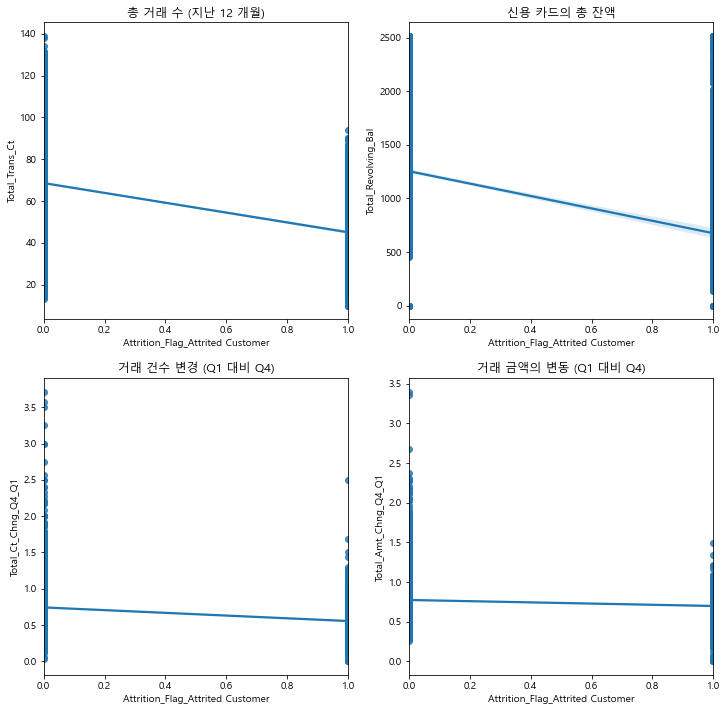

In [218]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12,12)

sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Trans_Ct', ax=ax1)
sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Revolving_Bal', ax=ax2)
sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Ct_Chng_Q4_Q1', ax=ax3)
sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Amt_Chng_Q4_Q1', ax=ax4)


ax1.set(title='총 거래 수 (지난 12 개월)')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')

1. 지난 12개월동안 총 거래 수가 적을 수록 이탈 가능성이 높다.
2. 신용카드의 총 잔액이 적을 수록 이탈 가능성이 높다.
3. 1분기 대비 4분기 거래 건수가 적을 수록 이탈 가능성이 높다.
4. 1분기 대비 4분기 거래 금액이 적을 수록 이탈 가능성이 높다.

## 5.2. XGBoost

In [219]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [220]:
X = train[input_var]
y = train['Attrition_Flag_Attrited Customer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape

(7595, 31)

In [221]:
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1)
xgb.fit(train[input_var], train['Attrition_Flag_Attrited Customer'])

[16:05:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [222]:
y_pred = xgb.predict(X_test)
y_true = y_test

In [223]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse

0.0

Attrition_Flag_Attrited Customer 는 0 또는 1의 값을 가지기에 해당 RMSE 결과는 약 2.8%의 오차율이라고 볼 수 있다.

In [224]:
import shap

In [225]:
shap_values = shap.TreeExplainer(xgb).shap_values(train[input_var])

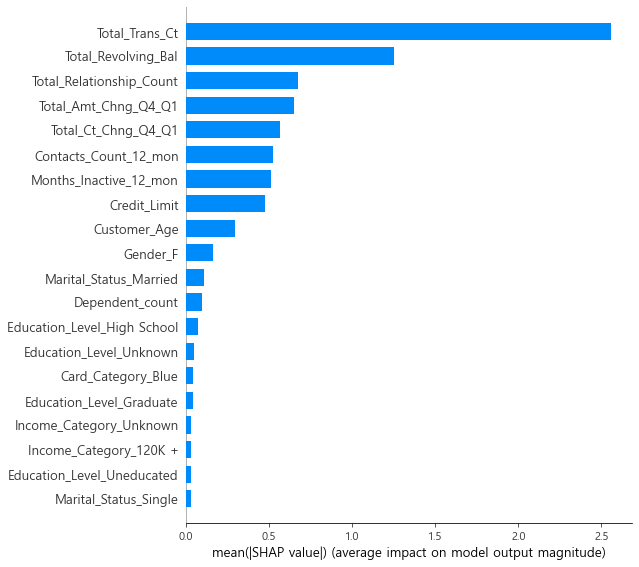

In [226]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

Random Forest에서의 변수중요도와는 다르게 Total_Relationship_Count가 4위에서 3위로 올라왔다.

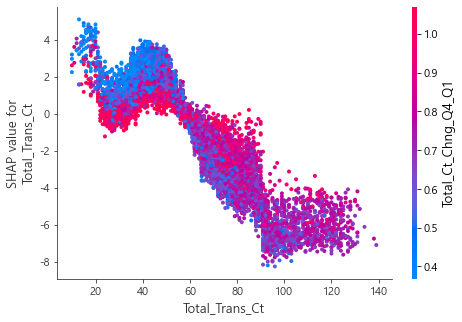

In [227]:
shap.dependence_plot('Total_Trans_Ct', shap_values, train[input_var])

- [지난 12개월의 총 거래수]가 많을수록 이탈 가능성은 낮아진다.
- 약 60회 이상이 되면 이탈 가능성이 안정적으로 계속 낮아진다.
- 90회 이상이 되면 이탈 가능성이 더이상 낮아지지는 않는다.

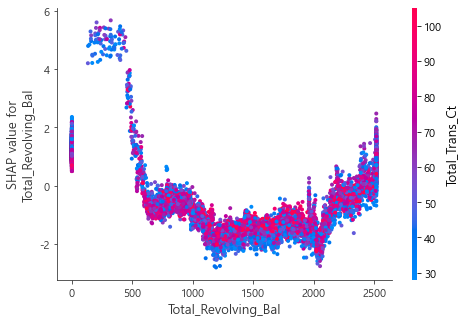

In [228]:
shap.dependence_plot('Total_Revolving_Bal', shap_values, train[input_var])

- [신용 카드의 총 잔액]이 600~2100 달러 일 때 이탈 가능성이 낮다.
- 600달러 미만일 경우 이탈 가능성이 아주 높아진다.

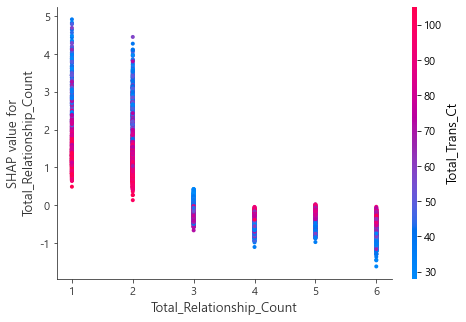

In [229]:
shap.dependence_plot('Total_Relationship_Count', shap_values, train[input_var])

- [고객이 보유한 카드 수]가 3개 미만 일 때는 이탈 가능성이 높고,3개 이상일 때 이탈 가능성이 낮다.
- 카드는 3개면서 총 거래수가 적을 경우 이탈 가능성이 다소 높아진다.

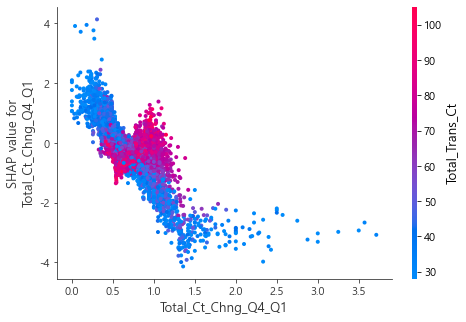

In [230]:
shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values, train[input_var])

- [1분기 대비 4분기 거래 건수]가 50% 이상이면 이탈 가능성이 낮아진다.
- 130% 이상일 경우 안정적으로 이탈 가능성이 낮다.
- 1분기 대비 4분기의 거래 건수가 거의 변화가 없으면서 총 거래수가 많을 경우 이탈 가능성이 높아진다.

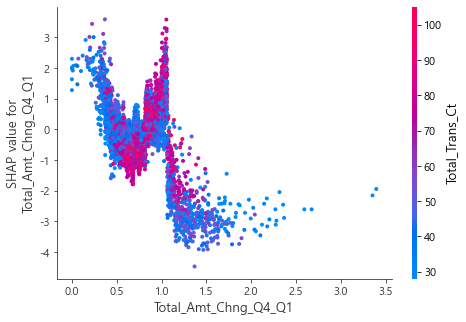

In [231]:
shap.dependence_plot('Total_Amt_Chng_Q4_Q1', shap_values, train[input_var])

- [1분기 대비 4분기 거래 금액]이 50~80%일 때 이탈 가능성이 낮고,
- 110% 이상일 때 안정적으로 이탈 가능성이 낮다.
- 1분기 대비 4분기의 거래 금액이 거의 변화가 없을 때도 이탈 가능성이 높아진다.

In [232]:
# 상위 4개 변수들의 값이 50%보다 큰 경우
group1 = train.loc[(train['Total_Trans_Ct'].quantile(0.5) < train['Total_Trans_Ct']) &
                   (train['Total_Revolving_Bal'].quantile(0.5) < train['Total_Revolving_Bal']) &
                   (train['Total_Relationship_Count'].quantile(0.5) < train['Total_Relationship_Count']) &
                   (train['Total_Ct_Chng_Q4_Q1'].quantile(0.5) < train['Total_Ct_Chng_Q4_Q1'])]

# 이 값들이 클 수록 이탈 가능성이 낮을 것이다.

In [233]:
# 상위 4개 변수들의 값이 50%보다 작은 경우
group2 = train.loc[(train['Total_Trans_Ct'].quantile(0.5) > train['Total_Trans_Ct']) &
                   (train['Total_Revolving_Bal'].quantile(0.5) > train['Total_Revolving_Bal']) &
                   (train['Total_Relationship_Count'].quantile(0.5) > train['Total_Relationship_Count']) &
                   (train['Total_Ct_Chng_Q4_Q1'].quantile(0.5) > train['Total_Ct_Chng_Q4_Q1'])]

# 이 값들이 작을 수록 이탈 가능성이 높을 것이다.

In [234]:
group1['group'] = '4개 변수의 값이 큰 경우'
group2['group'] = '4개 변수의 값이 작은 경우'

In [235]:
full = pd.concat([group1, group2], axis=0)

<AxesSubplot:xlabel='group', ylabel='Attrition_Flag_Attrited Customer'>

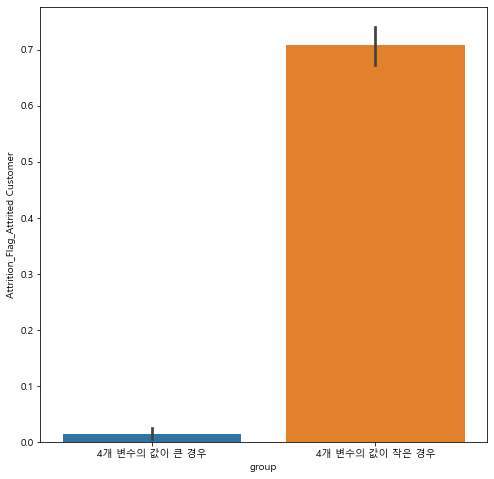

In [236]:
plt.figure(figsize=(8,8))
sns.barplot(x='group', y='Attrition_Flag_Attrited Customer', data=full)

4개 변수들의 값이 큰 경우(50% 초과) 이탈 가능성은 매우 낮아져 거의 2%에 가까운 반면,<br>
4개 변수들의 값이 작은 경우(50% 미만) 이탈 가능성은 약 70%에 육박한다는 것을 확실히 알 수 있다.

# 6. 결론

이탈 가능성이 높은 고객은 다음과 같다.
1. 지난 1년간 총 거래 횟수가 60회 미만
2. 신용카드 잔액이 600달러 미만
3. 보유한 카드 수가 3개 미만
4. 1분기 대비 4분기 거래 횟수가 50% 이하
5. 1분기 대비 4분기 거래 금액이 50% 이하이거나 80~100%

분석 전에 세운 가설인 <br>
'소득이 적을 수록, 카드 등급이 낮을 수록, 카드사용 금액이 적을 수록 이탈 가능성이 높을 것이다'<br>
와는 다르게 소득과 카드 등급은 이탈 가능성에 영향을 주지 못했다.<br>

#### EDA를 통해 고려해 볼 유효 서비스

1. 40대 중년층 고객이 많으므로 해당 연령대를 위한 혜택을 구상한다.
2. 평균 2.3명의 부양가족이 있으므로 관련 혜택을 구상한다.
3. 거래기간이 36개월인 고객이 압도적으로 많으므로, 3년전 데이터를 확인하여 고객수 급증의 원인을 파악해보고 현재 도입할 수 있는 방안은 무엇인지 확인한다.
4. 1분기의 거래 금액과 횟수에 비해 4분기의 실적이 저조하므로 원인을 파악하여 4분기 실적을 향상시킬 방안을 구상한다.

#### 두 모델링을 통해 본 고객이탈 방지를 위한 대책
1. 총 거래 금액보다는 거래 횟수가 더 중요하기 때문에 소액이라도 자주 카드를 사용할 수 있도록 관련 혜택들을 구상한다.
2. 2개 이하의 카드를 보유한 고객에게 줄 적절한 혜택을 구상하고, 보유 카드가 3개 이상이 되도록할 방안들을 마련한다.
3. 연말에 카드를 더 자주 사용할 수 있도록 관련 이벤트를 구상한다.